# This notebook is for the Fair-Shapely experiment

In [2]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [4]:
from src.data.unified_dataloader import load_dataset

a, processed_german_credit = load_dataset('german_credit')
# _, processed_uci = load_dataset('uci')

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64


In [5]:
processed_german_credit.head(3)

,Age,sex,Credit amount,Duration,Job_0,Job_1,Job_2,Job_3,Housing_free,Housing_own,...,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk
0,2.766456,0,-0.745131,-1.236478,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,-1.191404,1,0.949817,2.248194,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
2,1.183312,0,-0.416562,-0.738668,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


### 3. Split label/unlabel data, split train/test data.

In [6]:
'''UCI dataset'''
# df = processed_uci.copy()
# X = df.drop('income', axis=1)
# y = df['income']

'''German Credit dataset'''
df = processed_german_credit.copy()
X = df.drop('Risk', axis=1)
y = df['Risk']

# into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50) 
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (700, 26)
X_test shape: (300, 26)


### 4. Train the original model

In [7]:
model = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model.fit(X_train,y_train)

# 预测和评估
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.66


In [8]:
X_train['sex'].value_counts()

sex
0    482
1    218
Name: count, dtype: int64

In [9]:
'''把X_train分成majority和minority两个部分'''

male_condition = X_train['sex'] == 0
X_train_majority = X_train[male_condition]
y_train_majority = y_train[male_condition]

female_condition = X_train['sex'] == 1
X_train_minority = X_train[female_condition]
y_train_minority = y_train[female_condition]

### 5. Evaluate the performance of original model

In [10]:
from src.attribution.oracle_metric import perturb_numpy_ver
from src.attribution import FairnessExplainer
sen_att_name = ["sex"]
sen_att = [X_train.columns.get_loc(name) for name in sen_att_name]
priv_val = [1]
unpriv_dict = [list(set(X_train.values[:, sa])) for sa in sen_att]
for sa_list, pv in zip(unpriv_dict, priv_val):
    sa_list.remove(pv)
# print(f'sen_att_name:{sen_att_name}')
# print(f'sen_att:{sen_att}') # index of sensitive attribute
# print(f'priv_val:{priv_val}') # privileged value
# print(f'unpriv_dict:{unpriv_dict}') # unprivileged value(all values in the sensitive attribute, except the privileged value)



''' 
计算DR value的函数
'''
def fairness_value_function(sen_att, priv_val, unpriv_dict, X, model):
    X_disturbed = perturb_numpy_ver(
        X=X,
        sen_att=sen_att,
        priv_val=priv_val,
        unpriv_dict=unpriv_dict,
        ratio=1.0,
    )
    fx = model.predict_proba(X)[:, 1]
    fx_q = model.predict_proba(X_disturbed)[:, 1]
    return np.mean(np.abs(fx - fx_q))
original_train_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_train.values, model)
print(f'original_train_DR: {original_train_DR}')
original_test_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_test.values, model)
print(f'original_test_DR: {original_test_DR}')



c:\Users\ZhuLi\Anaconda3\envs\unlabel_fair\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


original_train_DR: 0.05932258442044258
original_test_DR: 0.07642389833927155


### 5. 把female和male匹配，（或者male和female匹配），然后进行修改，重新训练

2. 初始化FairnessExplainer
--------接下来先对minority group进行修改--------
3(a). 将X_train_minority_label0与X_train_majority_label0进行匹配
3(b). 将X_train_minority_label1与X_train_majority_label1进行匹配
4(a). 使用fairshap, 从 X_train_majority_label0中找到合适的值替换X_train_minority_label0中的数据
4(b). 使用fairshap, 从 X_train_majority_label1中找到合适的值替换X_train_minority_label1中的数据
5. 计算出varphi和q
在X_train_minority中shapely value中大于0.1的值的个数有: 50
--------接下来对majority group进行修改--------
3(a). 将X_train_majority_label0与X_train_minority_label0进行匹配
3(b). 将X_train_majority_label1与X_train_minority_label1进行匹配
4(a). 使用fairshap, 从 X_train_minority_label0中找到合适的值替换X_train_majority_label0中的数据
4(b). 使用fairshap, 从 X_train_minority_label1中找到合适的值替换X_train_majority_label1中的数据
5. 计算出varphi和q
在X_train_majority中shapely value中大于0.1的值的个数有: 57
6. 开始整理minority部分的修改和majority部分的修改并且合并新数据,共修改107个数据点, 使用new training set训练新模型


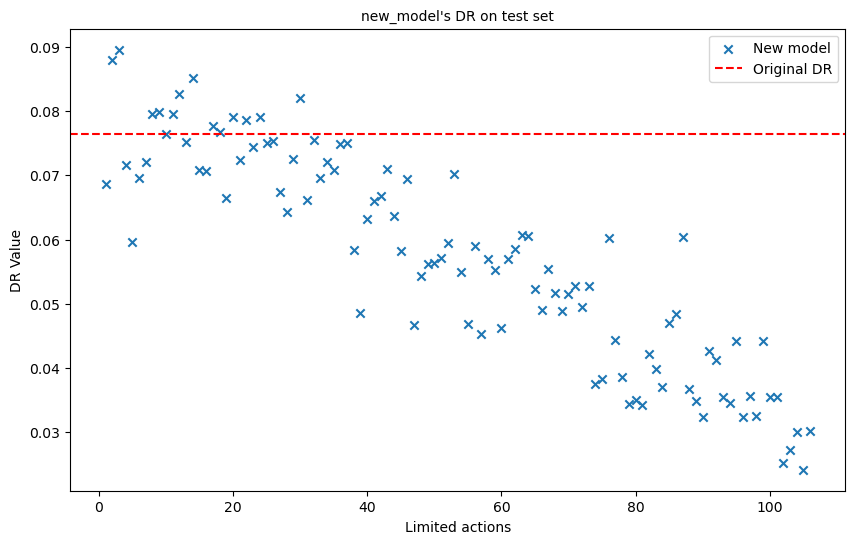

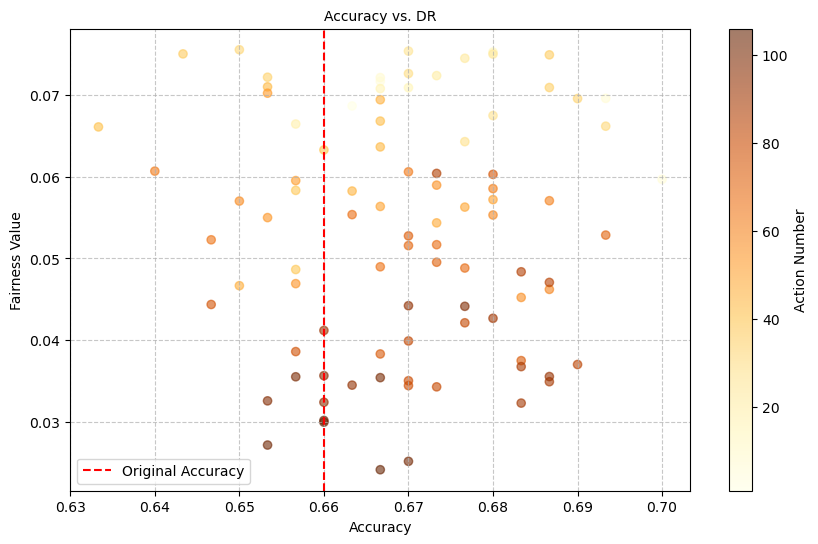

([0.0686235,
  0.08797629,
  0.0895453,
  0.071643144,
  0.059667747,
  0.0695531,
  0.072092675,
  0.079568274,
  0.07981,
  0.07650253,
  0.07955092,
  0.08263057,
  0.075211205,
  0.08518117,
  0.0708597,
  0.070744455,
  0.07767628,
  0.07673229,
  0.06641756,
  0.079054855,
  0.072331324,
  0.07862844,
  0.074448064,
  0.07905737,
  0.0749599,
  0.07532473,
  0.06744952,
  0.06426206,
  0.07258631,
  0.08196361,
  0.06615246,
  0.07549388,
  0.06952469,
  0.0721338,
  0.07087573,
  0.07486761,
  0.07498458,
  0.058310844,
  0.048641738,
  0.06325275,
  0.06606259,
  0.066775866,
  0.07096021,
  0.06362082,
  0.05822968,
  0.0693833,
  0.046668142,
  0.054342695,
  0.05626738,
  0.056345843,
  0.05718172,
  0.05950725,
  0.07018425,
  0.05498539,
  0.046917148,
  0.058951315,
  0.04522966,
  0.05700414,
  0.055299923,
  0.04621516,
  0.057048034,
  0.058528367,
  0.060662586,
  0.060577393,
  0.05227199,
  0.048975512,
  0.055349223,
  0.051674828,
  0.048823476,
  0.0515656,
  0.0

In [ ]:
from src.experiments import Experiment

experiment = Experiment(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='german_credit',
                            original_Xtest_DR = original_test_DR,
                            original_Xtest_acc = accuracy,
                            )
experiment.run_experiment()


In [22]:
''' Experiment new

1. 从majority parity(此处男性)中随机选择30%, 50%, 70%的比例，作为将被替换的数据集X_train_replace_majority,剩余部分为X_train_rest_majority
2. 将X_train_minority与X_train_replace_majority进行匹配
3. 使用fairshap,把X_train_minority作为baseline dataset，找到X_train_replace_majority中需要替换的数据，假设总共需要替换n个数据点
4. (1,n,20)根据这些,分别计算替换(1,n)中不同个数的结果,把需要替换的数据替换到X_train_replace_majority中,得到X_train_replace_majority_new
5. 把X_train_replace_majority_new和X_train_rest_majority,还有X_train_minority合并,得到新的X_train_new，然后重新训练，得到新的模型model_new，计算新的DR值

----------   循环 30%, 50%, 70%的比例，以及不同的n值，得到DR值的变化  -------------------
'''

' Experiment new\n\n1. 从majority parity(此处男性)中随机选择30%, 50%, 70%的比例，作为将被替换的数据集X_train_replace_majority,剩余部分为X_train_rest_majority\n2. 将X_train_minority与X_train_replace_majority进行匹配\n3. 使用fairshap,把X_train_minority作为baseline dataset，找到X_train_replace_majority中需要替换的数据，假设总共需要替换n个数据点\n4. (1,n,20)根据这些,分别计算替换(1,n)中不同个数的结果,把需要替换的数据替换到X_train_replace_majority中,得到X_train_replace_majority_new\n5. 把X_train_replace_majority_new和X_train_rest_majority,还有X_train_minority合并,得到新的X_train_new，然后重新训练，得到新的模型model_new，计算新的DR值\n\n----------   循环 30%, 50%, 70%的比例，以及不同的n值，得到DR值的变化  -------------------\n'